In [2]:
#this notbook is for testing out little bits of code that could be useful in the overall pipeline.
#API calls, reading alignments, running other software stuff etc
#I've added some comments in cells for some small tasks we might need to do often.
#It would be good to have some sanity check outputs for each task to make sure the code is working


In [3]:
#setup folders
import os
import glob
folders = [ 'alns' , 'templates' , 'TensorflowModels' ]
clear = False

for path in folders:
    if not os.path.isdir(path):
        os.mkdir(path)
    if clear == True:
        files = glob.glob(path+'*.pdb')
        for f in files:
            os.remove(f)
            

In [69]:
#dl pdb files
#this uses wget to download individual pdb files and stores the paths

import wget
import glob
import time

models = '1ok8 1oan'.split()

dl_url = 'http://files.rcsb.org/download/'
dl_url_err = 'http://files.rcsb.org/download/'
structs = {}
already = glob.glob( './templates/*.pdb' )
print(already)

#pull complexes
for m in models:
    structfile = './templates/'+m.upper().strip()+'.pdb'
    if structfile not in already:
        print(m)
        time.sleep(1)
        try:
            wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
            structs[m] = structfile
        except:
            try:
                wget.download(url = dl_url + m.strip() +'.pdb' , out =structfile)
                structs[m] = structfile
            except:
                print('err', m )
    else:
        structs[m.strip()] = structfile
        
print(structs)

['./templates/1OK8.pdb', './templates/1OAN.pdb']
{'1ok8': './templates/1OK8.pdb', '1oan': './templates/1OAN.pdb'}
<class 'dict'>


In [5]:
#grab sequences in AA from the PDB files

from Bio.SeqUtils import seq1
from Bio.PDB.PDBParser import PDBParser

parser = PDBParser()
#converter from 3 letter codes to 1 letter
#letter3 = Alphabet.ThreeLetterProtein.letters
converter = {'ALA': 'A', 'ASX': 'B', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F', 'GLY': 'G',
             'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L', 'MET': 'M', 'ASN': 'N', 'PRO': 'P',
             'GLN': 'Q', 'ARG': 'R', 'SER': 'S', 'THR': 'T', 'SEC': 'U', 'VAL': 'V', 'TRP': 'W',
             'XAA': 'X', 'TYR': 'Y', 'GLX': 'Z'}
structseqs={}
with open( 'structs.fast' , 'w')as fastout:
    for s in structs:
        Structure = PDBParser().get_structure(s, structs[s])
        for model in Structure:
            for chain in model:
                res = chain.get_residues()
                seq =  ''.join([ converter[r.get_resname()] for r in res if r.get_resname() in converter ] )
                fastout.write('>' + s + '|'+ chain.id +'\\n')
                fastout.write(str( seq ) +'\\n'  )
                structseqs[ s + '|'+ chain.id ] = seq

/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6846.
  PDBConstructionWarning,
/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6861.
  PDBConstructionWarning,
/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6875.
  PDBConstructionWarning,
/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6895.
  PDBConstructionWarning,


In [6]:
#proto for a function that opens an external program. pretty useful since we're using a lot of 3rd party tools

import subprocess
import shlex

def runclustalo( infile , runIdentifier, path = 'clustalo' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that step
    outfile= outdir+runIdentifier+infile+".aln.fasta"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args )
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to
    return p , outfile

In [7]:
# add the amino acid sequence from the 3d structure to an aligment
# run clustalo merge

In [18]:
#read aln 2 numpy matrix

import numpy as np
from Bio import AlignIO

alnfile = 'test_aln.fasta'
msa = AlignIO.read(alnfile , format = 'fasta')
align_array = np.array([ list(rec.upper())  for rec in msa], np.character)
print(align_array)

#function form
def alnFileToArray(filename):
    alnfile = filename
    msa = AlignIO.read(alnfile , format = 'fasta')
    align_array = np.array([ list(rec.upper())  for rec in msa], np.character)
    
    return align_array

[[b'N' b'N' b'A' ... b'T' b'I' b'T']
 [b'N' b'N' b'A' ... b'N' b'I' b'S']
 [b'E' b'N' b'A' ... b'T' b'I' b'T']
 ...
 [b'L' b'Y' b'P' ... b'T' b'I' b'R']
 [b'R' b'N' b'A' ... b'D' b'V' b'T']
 [b'P' b'T' b'A' ... b'Q' b'V' b'S']]


/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Converting `np.character` to a dtype is deprecated. The current result is `np.dtype(np.str_)` which is not strictly correct. Note that `np.character` is generally deprecated and 'S1' should be used.
  


In [9]:
#run dssp on a struct

import subprocess
import shlex

def rundssp( infile , runIdentifier, path = 'dssp' , outdir='./', args = '' , verbose = False):
    if verbose == True:
        print( infile , runIdentifier , path , outdir )
    #i usually use filenames that reflect what the pipeline has done until that step
    outfile= outdir+runIdentifier+infile+".dssp"
    
    #here we write the command as a string using all the args
    args = path + ' -i '+  infile  +' -o '+ outfile + ' ' +args
    args = shlex.split(args)
    if verbose == True:
        print(args)
    p = subprocess.Popen(args)
    #return the opened process and the file it's creating
    
    #we can also use the communicate function later to grad stdout if we need to
    return p , outfile

#not working at the moment due to permissions for some reason...
for s in structs:
    print(structs[s])
    p, outdssp = rundssp( structs[s] , 'test' , outdir = './templates/' , verbose = True)
    p.wait()

./templates/1OK8.pdb
./templates/1OK8.pdb test dssp ./templates/
['dssp', '-i', './templates/1OK8.pdb', '-o', './templates/test./templates/1OK8.pdb.dssp']
./templates/1OAN.pdb
./templates/1OAN.pdb test dssp ./templates/
['dssp', '-i', './templates/1OAN.pdb', '-o', './templates/test./templates/1OAN.pdb.dssp']


In [10]:
#dssp to pandas
import pandas as pd
def dssp2pandas(dsspstr):
    #read the dssp file format into a pandas dataframe
    start = False
    lines = {}
    count = 0
    for l in dsspstr.split('\n'):
        if '#' in l:
            start = True
        if start == True:
            if count > 0:
                lines[count] = dict(zip(header,l.split()))
            else:
                header = l.split()
            count +=1
    df = pd.DataFrame.from_dict( lines , orient = 'index')
    return df


dssps= glob.glob( './templates/*.dssp')
print(dssps)
for dssp in dssps:
    with open( dssp , 'r') as dsspin:
        df = dssp2pandas( dsspin.read() )
        print(df)

['./templates/1OAN.pdb.dssp']
       # RESIDUE AA STRUCTURE BP1 BP2  ACC   N-H-->O   O-->H-N       TCO  \
1      1       1  A         M   >   0    0       0.0  151,-2.8        0,   
2      2       2  A         R   T   3    +        33  140,-0.2  495,-0.0   
3      3       3  A         a   T   >   S+         0  139,-0.2    3,-2.5   
4      4       4  A         I   T   <   S+         1   -3,-0.6  493,-0.4   
5      5       5  A         G   T   3   S+        20   -2,-0.6    2,-0.4   
..   ...     ... ..       ...  ..  ..  ...       ...       ...       ...   
785  785     390  B         N   E  -C  772  -13,-0.2    2,-0.3  -15,-0.0   
786  786     391  B         W   E  -C  771  -15,-2.3  -15,-1.0   -2,-0.2   
787  787     392  B         F   E  -C  770   -2,-0.3    2,-0.3  -17,-0.2   
788  788     393  B         K   E   C  769  -19,-2.1  -19,-1.8   -2,-0.4   
789  789     394  B         K   0   0  192  -21,-0.2   -2,-0.0    -0.020   

        KAPPA     ALPHA               PHI          PSI   

In [11]:
#run protFet on a sequence

import sys
#add profet to python path
sys.path.append('./ProFET/ProFET/feat_extract/')
import FeatureGen

#function to call when generating array over align
def generateProtFET(sequence):
    features = FeatureGen.Get_Protein_Feat(sequence)
    featuresNp = np.array(list(features.values()))
    return featuresNp

#to get dictionary and not array
def generateProtFETDict(sequence):
    features = FeatureGen.Get_Protein_Feat(sequence)
    return features

for s in structseqs:
    print(structseqs[s])
    features = FeatureGen.Get_Protein_Feat(structseqs[s])
    #print(features)
    #transform features dictionary into an array
    featuresNp = np.array(list(features.values()))
    print(featuresNp)
    
#works!

MRCIGISNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELIKTEAKQPATLRKYCIEAKLTNTTTESRCPTQGEPTLNEEQDKRFVCKHSMVDRGWGNGCGLFGKGGIVTCAMFTCKKNMEGKIVQPENLEYTVVITPHGKEVKITPQSSITEAELTGYGTVTMECSPRTGLDFNEMVLLQMKDKAWLVHRQWFLDLPLPWLPGADTQGSNWIQKETLVTFKNPHAKKQDVVVLGSQEGAMHTALTGATEIQMSSGNLLFTGHLKCRLRMDKLQLKGMSYSMCTGKFKVVKEIAETQHGTIVIRVQYEGDGSPCKIPFEIMDLEKRHVLGRLITVNPIVTEKDSPVNIEAEPPFGDSYIIIGVEPGQLKLNWFKK
[3.684 3.421 3.158 ... 0.    0.26  0.   ]
MRCIGISNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELIKTEAKQPATLRKYCIEAKLTNTTTESRCPTQGEPTLNEEQDKRFVCKHSMVDRGWGNGCGLFGKGGIVTCAMFTCKKNMEGKIVQPENLEYTVVITPHSGEEHAVGNDTGKHGKEVKITPQSSITEAELTGYGTVTMECSPRTGLDFNEMVLLQMKDKAWLVHRQWFLDLPLPWLPGADTQGSNWIQKETLVTFKNPHAKKQDVVVLGSQEGAMHTALTGATEIQMSSGNLLFTGHLKCRLRMDKLQLKGMSYSMCTGKFKVVKEIAETQHGTIVIRVQYEGDGSPCKIPFEIMDLEKRHVLGRLITVNPIVTEKDSPVNIEAEPPFGDSYIIIGVEPGQLKLNWFKK
[3.553 3.299 3.046 ... 0.    0.25  0.   ]
MRCIGISNRDFVEGVSGGSWVDIVLEHGSCVTTMAKNKPTLDFELIKTEAKQPATLRKYCIEAKLTNTTTESRCPTQGEPTLNEEQDKRFVCKHSMVDRGWGNGCGLFGKGGIVTCAMFTCKKNMEGKIVQPENLEYTVV

AttributeError: 'ProtFeat' object has no attribute 'alph_set'

In [12]:
#now we need property dictionaries for the amino acids

/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6846.
  PDBConstructionWarning,
/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6861.
  PDBConstructionWarning,
/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6875.
  PDBConstructionWarning,
/home/osboxes/miniconda3/envs/structML/lib/python3.7/site-packages/Bio/PDB/StructureBuilder.py:92: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6895.
  PDBConstructionWarning,


1ok8


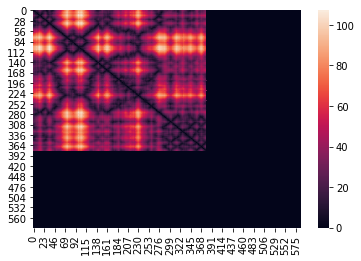

1oan


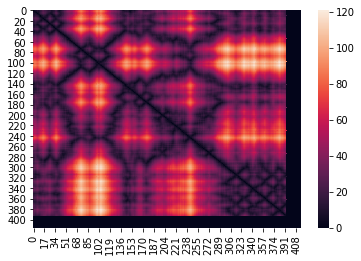

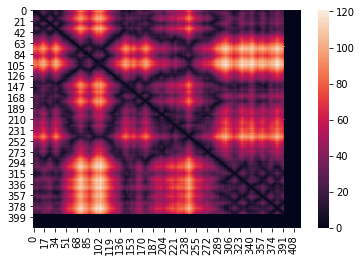

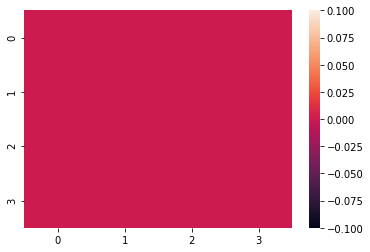

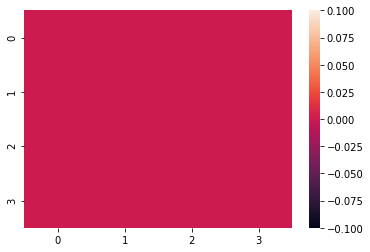

In [13]:
#pdb 2 distmat

#from Bio import Alphabet
from Bio.SeqUtils import seq1
from Bio.PDB.PDBParser import PDBParser
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

distances = {}
for s in structs:
    Structure = PDBParser().get_structure(s, structs[s])
    distances[s] = {}
    for model in Structure:
        for chain in model:
            res = [r for r in chain.get_residues()]
            distmat = [ [res2['CA'] - res1['CA'] if 'CA' in res1 and 'CA' in res2 and i > j else 0 for i,res1 in enumerate(res)] for j,res2 in enumerate(res)]
            distmat = np.array(distmat)
            distmat+= distmat.T
            distances[s][chain] = distmat
            
for s in distances:
    print(s)
    for c in distances[s]:
        sns.heatmap(distances[s][c])
        plt.show()

In [52]:
#make list of proteins, containing list of distance arrays for each chain
protChainsList = list()
chainDistArrayList = list()

for protein in distances:
    for chain in distances[protein]:
        distArray = np.array(distances[protein][chain])
        if np.sum(distArray) != 0:
            chainDistArrayList.append(distArray)
    protChainsList.append(chainDistArrayList)
    chainDistArrayList = list()

#preserve original shape before flattening
chainAmounts = np.array((len(protChainsList),1), dtype=int)
for i in range(len(protChainsList)):
    chainAmounts[i] = len(protChainsList[i])

#flatten 2D list into 1D list
arrayList = list()
[[arrayList.append(protChainsList[i][j]) for j in range(chainAmounts[i])] for i in range(len(protChainsList))]

#find size of the largest distmat
maxX = 0
maxY = 0
for mat in arrayList:
    if mat.shape[0] > maxX:
        maxX = mat.shape[0]
    if mat.shape[1] > maxY:
        maxY = mat.shape[1]

print("biggest: ", maxX, " ", maxY)
#pad the arrays so they're all the same size
for i in range(len(arrayList)):
    padded = np.zeros((maxX, maxY))
    padded[:arrayList[i].shape[0], :arrayList[i].shape[1]] = arrayList[i]
    arrayList[i] = padded

#make 3D array of all distmats in the set
distmats = np.zeros((len(arrayList), maxX, maxY))

for mat in arrayList:
    distmats[i,:,:] = arrayList[i]

#apply fft to each chain distmat and separate real and imaginary parts
for i in range(len(arrayList)):
    arrayList[i] = np.fft.fft2(arrayList[i])

arrayListReal = list()
arrayListIm = list()
[arrayListReal.append(np.real(arrayList[i])) for i in range(len(arrayList))]
[arrayListIm.append(np.imag(arrayList[i])) for i in range(len(arrayList))]

#reshape the lists to the original 2D structure
protChainsReal = list()
protChainsIm = list()
chainDistArrayListReal = list()
chainDistArrayListIm = list()
totBefore = 0

for i in range(len(chainAmounts)):
    for k in range(i):
        totBefore += chainAmounts[i-1]
    for j in range(chainAmounts[i]):
        chainDistArrayListReal.append(arrayListReal[totBefore + j])
        chainDistArrayListIm.append(arrayListIm[totBefore + j])
    protChainsReal.append(chainDistArrayListReal)
    chainDistArrayListReal = list()
    protChainsIm.append(chainDistArrayListIm)
    chainDistArrayListIm = list()

biggest:  587   587


In [61]:
#preparing the output space

import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler,  Normalizer , MinMaxScaler , RobustScaler
from sklearn.decomposition import PCA

#fft ndim tools. transforms the output distance matrices into a set of pca components derived from the
#fourier spectrum of the input

#Ndimensional robust scaler for arrays

#use this on alpha carbon distmats from known protein structs

class NDSRobust(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = RobustScaler(copy=True, **kwargs)
        self._orig_shape = None

    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        return self
    
    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X
    
    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X

#ndimensional PCA for arrays

class NDSPCA(TransformerMixin):
    def __init__(self, **kwargs):
        self._scaler = PCA(copy = True, **kwargs)
        self._orig_shape = None
    
    def fit(self, X, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X, **kwargs)
        self.explained_variance_ratio_ = self._scaler.explained_variance_ratio_
        self.components_ =self._scaler.components_
        
        return self
    
    def transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X, **kwargs)
        
        return X
    
    def inverse_transform(self, X, **kwargs):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.inverse_transform(X, **kwargs)
        X = self._reshape(X)
        return X
    
    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X
    
    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X
    
#fit the components of the output space
#stacked distmats (on the 1st axis)
def fit_y( y , components = 300 , FFT = True ):
    if FFT == True:
        #got through a stack of structural distmats. these should be 0 padded to all fit in an array
        
        y = np.stack([ np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])] )
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
    print(y.shape)
    ndpca = NDSPCA(n_components=components)
    ndpca.fit(y)
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
    y = ndpca.transform(y)
    scaler0 = RobustScaler( )
    scaler0.fit(y)
    return scaler0, ndpca

def transform_y(y, scaler0, ndpca, FFT = False):
    if FFT == True:
        y = np.stack([np.fft.rfft2(y[i,:,:]) for i in range(y.shape[0])])
        print(y.shape)
        y =  np.hstack( [ np.real(y) , np.imag(y)]  )
    y = ndpca.transform(y)
    print(y.shape)
    y = scaler0.transform(y)
    
    return y

def inverse_transform_y(y, scaler0, ndpca, FFT=False):
    y = scaler0.inverse_transform(y)
    y = ndpca.inverse_transform(y)
    
    if FFT == True:
        split = int(y.shape[1]/2)
        y = np.stack([ np.fft.irfft2(y[i,:split,:] + 1j*y[i,split:,:]) for i in range(y.shape[0]) ] )
        
    return y

#fit the components of the in space
#stacked align voxels (on the 1st axis)
def fit_x(x, components = 300, FFT = True):
    if FFT == True:
        #got through a stack of align voxels. these should be 0 padded to all fit in an array
        
        x = np.stack([ np.fft.rfftn(x[i,:,:,:]) for i in range(x.shape[0])] )
        print(x.shape)
        x =  np.hstack( [ np.real(x) , np.imag(x)]  )
    print(x.shape)
    ndpca = NDSPCA(n_components=components)
    ndpca.fit(x)
    print('explained variance')
    print(np.sum(ndpca.explained_variance_ratio_))
    x = ndpca.transform(x)
    scaler0 = RobustScaler( )
    scaler0.fit(x)
    return scaler0, ndpca

def transform_x(x, scaler0, ndpca, FFT = False):
    if FFT == True:
        x = np.stack([ np.fft.rfftn(x[i,:,:,:]) for i in range(x.shape[0])] )
        print(x.shape)
        x =  np.hstack( [ np.real(x) , np.imag(x)]  )
    x = ndpca.transform(x)
    print(x.shape)
    x = scaler0.transform(x)
    
    return x

#todo -- check the split is happening in the right dimension
def inverse_transform_x(x, scaler0, ndpca, FFT=False):
    x = scaler0.inverse_transform(x)
    x = ndpca.inverse_transform(x)
    
    if FFT == True:
        split = int(x.shape[1]/2)
        x = np.stack([ np.fft.irfftn(x[i,:split,:,:] + 1j*x[i,split:,:,:]) for i in range(x.shape[0]) ] )
        
    return x


In [16]:
propfile = './physicalpropTable.csv'
propdf = pd.read_csv(propfile)
print(propdf)

numerical = [ 'pKa side chain', 'pka2', 'pka3',
              'PI', 'Solubility Molal', 'MW', 'charge', 'ww hydrophob scale',
              'hydr or amine', 'aliphatic', 'aromatic', 'hydrophobicity at ph7']
properties = { prop: dict(zip(propdf['letter Code' ] , propdf[prop] ) ) for prop in numerical }
properties = { prop:{c.encode(): properties[prop][c] for c in properties[prop]} for prop in properties}
print(properties)

   Amino Acid Name letter Code  pKa side chain  pka2   pka3     PI  \
0          Alanine           A            0.00  2.34   9.69   6.00   
1         Arginine           R           12.00  2.17   9.04  10.76   
2    Aspartic Acid           D            4.50  1.88   9.60   5.41   
3       Asparagine           N            0.00  2.02   8.80   2.77   
4         Cysteine           C           13.85  1.96   8.18   5.07   
5    Glutamic Acid           E            4.60  2.19   9.67   3.22   
6        Glutamine           Q            0.00  2.17   9.13   5.65   
7          Glycine           G            0.00  2.34   9.60   5.97   
8        Histidine           H            6.20  1.82   9.17   7.59   
9       Isoleucine           I            0.00  2.36   9.60   6.02   
10         Leucine           L            0.00  2.36   9.60   5.98   
11          Lysine           K           10.40  2.18   8.95   9.74   
12      Methionine           M            0.00  2.28   9.21   5.74   
13   Phenylalanine  

In [38]:
#used to check which features are missing from shorter protFET arrays and complete them
dictKeys = set()

for i in range(align_array.shape[0]):
    sequence = str(msa[i].seq)
    sequence = sequence.replace('.', '')
    sequence = sequence.replace('-','')
    dictKeys = dictKeys.union(set(generateProtFETDict(sequence).keys()) - dictKeys)
    
#generate 2d array of ProtFET features for each sequence in align
align_features = np.zeros((align_array.shape[0], len(dictKeys)), dtype=float)
missingFeatures = set()

for i in range(align_array.shape[0]):
    sequence = str(msa[i].seq)
    sequence = sequence.replace('.', '')
    sequence = sequence.replace('-','')
    featuresDict = generateProtFETDict(sequence)
    missingFeatures = dictKeys - set(featuresDict.keys())
    for newKey in missingFeatures:
        featuresDict[newKey] = float(0)
    features = np.array(list(featuresDict.values()))
    align_features[i,:] = features

#generate 3d array of aligns + properties
align_prop_array = np.zeros((align_array.shape[0], align_array.shape[1], len(numerical)), dtype=float)

for i in range(align_array.shape[0]):
    align_prop_array[i,:,:] = [[properties[prop][bstring] for prop in numerical] for bstring in align_array[i]]

#function form
def generateAlignVoxel(align_array):
    align_prop_array = np.zeros((align_array.shape[0], align_array.shape[1], len(numerical)), dtype=float)

    for i in range(align_array.shape[0]):
        align_prop_array[i,:,:] = [[properties[prop][bstring] for prop in numerical] for bstring in align_array[i]]
    
    return align_prop_array
    
#generate 4D array of stacked 3D voxels for FFT (and PCA)
directory = "alns"
aligns = list()

#read through align files to get align arrays list
for file in os.listdir(directory):
    if file.endswith('.fasta'):
        aligns.append(alnFileToArray(directory+'/'+file))

#find biggest align_array (the depth of the voxel is fixed by the number of properties)
longestProts = 0
mostProts = 0

for aln in aligns:
    if aln.shape[0] > mostProts:
        mostProts = aln.shape[0]
    if aln.shape[1] > longestProts:
        longestProts = aln.shape[1]

print("biggest: ", mostProts, " ", longestProts)

#pad all aligns (with 'b'.) to be the same size
for i in range(len(aligns)):
    padded = np.full((mostProts, longestProts), b'.')
    padded[:aligns[i].shape[0],:aligns[i].shape[1]] = aligns[i]
    aligns[i] = padded

#generate voxel array
voxels = np.zeros((len(aligns), mostProts, longestProts, len(numerical)))
print(voxels.shape)
for i in range(len(aligns)):
    voxels[i, :, :, :] = generateAlignVoxel(aligns[i])
    
#fft and split into real and imaginary arrays
align_prop_transform = np.fft.fftn(align_prop_array)
align_prop_transform_real = np.real(align_prop_transform)
align_prop_transform_im = np.imag(align_prop_transform)

In [65]:
#apply FFT and PCA to align voxels and distmats

print("VOXELS: ")
scalerX, ndpcaX = fit_x(voxels, components = 2, FFT = True)
transformed_voxels = transform_x(voxels, scalerX, ndpcaX, FFT = True)

print("DISTMATS: ")
scalerY, ndpcaY = fit_y(distmats, components = 3, FFT = True)
transformed_distmats = transform_y(distmats, scalerY, ndpcaY, FFT = True)

VOXELS: 
(2, 25, 144, 7)
(2, 50, 144, 7)
explained variance
1.0
(2, 25, 144, 7)
(2, 2)
DISTMATS: 
(3, 587, 294)
(3, 1174, 294)
explained variance
1.0
(3, 587, 294)
(3, 3)


In [68]:
#preparing the input

#read an aln



#use linear representation of each sequence

#w or without gaps

#compile 3d mat of nseq x columns x properties

#fft to 3d mat of components

#clip higher freqs

<class 'Bio.Align.MultipleSeqAlignment'>
<class 'numpy.ndarray'>
